# Well balanced second order MUSCL Scheme for the Shallow Water Equations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import muscl2

## MUSCL reconstruction 
Using $U=(h,hu)$ the first reconstruction consists of
* Obtain reconstructed values of conserved variables $U_{i,r},U_{i,l}$ 
* Reconstruct free surface elevation $H_{i,l}$ and $H_{i,r}$ where $H=h+d$
* Obtain topography values $d_{i,l}$ and $d_{i,r}$, where $d=H-h$, con $H$ y $h$ from the reconstruction


In [4]:
def minmod(slope1, slope2):
    if (slope1>0 and slope2 > 0):
        return min(slope1,slope2)
    if (slope1<0 and slope2<0):
        return max(slope1,slope2)
    return 0.
minmod = np.vectorize(minmod)

In [5]:
def musclReconstr(ul,uc,ur,dx):
    slopeb = (uc-ul)/dx
    slopef = (ur-uc)/dx
    slope = minmod(slopeb,slopef)
    uil = uc - 0.5*dx*slope
    uir = uc + 0.5*dx*slope
    
    return uil, uir

In [6]:
def allMusclReconstr(Ul,Uc,Ur,dl,dc,dr,dx=1):
    """
        Receives states U=(h,hu) and topography d, from a cell (say 1) 
        and its first neighbors (0 and 2) 
        and returns muscl reconstruction U_{il} and U_{ir} and
        d_{il}, d_{ir} of conserved variables and bathymetry at
        cell boundaries
        
        U0,U1,U2,d0,d1,d2 are 
        
        dx is irrelevant for regular grids
        but is kept for code semantic and mantainability
    """
    hl = Ul[0]
    ul = 0.0
    if hl>1e-5: ul = Ul[1]/hl

    hc = Uc[0]
    uc = 0.0
    if hc>1e-5: uc = Uc[1]/hc
        
    hr = Ur[0]
    ur = 0.0
    if hr>1e-5: ur = Ur[1]/hr
        
    #conserved variables u
#     Uil, Uir = musclReconstr(Ul,Uc,Ur,dx)
    hil, hir = musclReconstr(hl,hc,hr,dx)
    uil, uir = musclReconstr(ul,uc,ur,dx)
    
    
    #free surface H
    Hl = Ul[0] + dl
    Hc = Uc[0] + dc
    Hr = Ur[0] + dr
    
    Hil, Hir = musclReconstr(Hl, Hc, Hr, dx)

    #topography d
#     d_il = Hil - Uil[0]
#     d_ir = Hir - Uir[0]
    d_il = Hil - hil
    d_ir = Hir - hir
    
    Uil = np.array([hil,hil*uil])
    Uir = np.array([hir,hir*uir])
    return d_il, d_ir , Uil, Uir

In [7]:
def getMusclReconstr(d,h,hu):
    """
    Receives d (1,nx+4) and h,hu (1,nx+4)
    and returns dl,dr,ul,ur (1\times nx+2)
    for cells -1 to nx (innercells + 1ghost at each end)
    """
    nx = d.shape[0]-4
    dl = np.zeros((nx+2,))
    dr = np.zeros((nx+2,))
    hl = np.zeros((nx+2,))
    hr = np.zeros((nx+2,))
    hul = np.zeros((nx+2,))
    hur = np.zeros((nx+2,))
    for i in range(1,nx+3,1):
        u0 = np.array([h[i-1],hu[i-1]])
        u1 = np.array([h[i],hu[i]])
        u2 = np.array([h[i+1],hu[i+1]])
        d0 = d[i-1]
        d1 = d[i]
        d2 = d[i+1]
        dl[i-1], dr[i-1], (hl[i-1],hul[i-1]), (hr[i-1],hur[i-1]) = musclrecontr(u0,u1,u2,d0,d1,d2)
    return dl, dr, hl, hr, hul, hur        

In [8]:
def getMusclReconstr(d,hn,hun):
    """
    Receives d (1,nx+4) and h,hu (1,nx+4)
    and returns dl,dr,ul,ur (1\times nx+2)
    for innercells + 1ghost at each end
    
    0, [1, (2, ... , nx, nx+1), nx+2], nx+3
    
    that is, for cells 1 to nx+2 = range(1,nx+3)
    """
    nx = d.shape[0]-4
    dl = np.zeros((nx+2,))
    dr = np.zeros((nx+2,))
    hl = np.zeros((nx+2,))
    hr = np.zeros((nx+2,))
    hul = np.zeros((nx+2,))
    hur = np.zeros((nx+2,))
    for i in range(1,nx+3,1):
        u0 = np.array([hn[i-1],hun[i-1]])
        
        u1 = np.array([hn[i],hun[i]])
        
        u2 = np.array([hn[i+1],hun[i+1]])
        
        d0 = d[i-1]
        d1 = d[i]
        d2 = d[i+1]
        
        
#         return d_il, d_ir , Uil, Uir
        dl[i-1], dr[i-1], (hl[i-1],hul[i-1]), (hr[i-1],hur[i-1]) = allMusclReconstr(u0,u1,u2,d0,d1,d2)
    #
    return dl, dr, hl, hr, hul, hur        

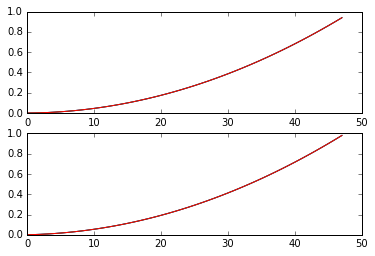

In [9]:
d = np.linspace(0,1)**2
h = np.copy(d)
hu = np.copy(d)
dl, dr, hl, hr, hul, hur = getMusclReconstr(d,h,hu)
plt.subplot(211)
plt.plot(dl)
plt.plot(hl)
plt.plot(hul)
plt.subplot(212)
plt.plot(dr)
plt.plot(hr)
plt.plot(hur)

In [10]:
u0 = np.array([0.,1.])
u1 = np.array([1.,2.])
u2 = np.array([0.,5.])
d0 = 0.
d1 = 1.
d2 = 1.5
dl, dr, (hl,hul), (hr,hur) = allMusclReconstr(u0,u1,u2,d0,d1,d2)
print dl,dr,hl,hul,hr,hur


1.0 1.0 1.0 2.0 1.0 2.0


(-1, 6)

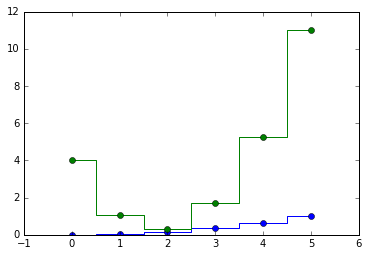

In [11]:
nx = 5 
x = np.linspace(0,5,6)
d = np.linspace(0,1,6)**2
h = d+(x-2)**2
hu = np.linspace(0,0.5,6)**2
plt.step(x,d,'o',where='mid')
plt.step(x,h+d,'o',where='mid')
plt.xlim(-1,6)
# plt.ylim(-1,11)

## Hydrostatic reconstruction
* Interface topography values are defined as $$d_{i+1/2} = max(d_{i,r}, d_{i+1,l})$$
* And water height at each side of interfaces as

$$h_{i+1/2-} = max(0, h_{i,r} +d_{i,r} - d_{i+1/2})$$
  $$h_{i+1/2+} = max(0, h_{i+1,l}+d_{i+1,l}-d_{i+1/2})$$
  
* Finally, conserved values at each side of the interface

$$ U_{i+1/2-} = (h_{i+1/2-}, h_{i+1/2-} u_{i,r})^t$$
$$ U_{i+1/2+} = (h_{i+1/2+}, h_{i+1/2+} u_{i+1,l})^t$$

In [12]:
#recibe dl,dr,hl,hr,hul,hur (nx-2, sigo el ejemplo de arriba)
#entrega valores plus minus de la reconstruccion hidrostatica
def getHydrReconstr(dl,dr,hl,hr,hul,hur):
    """
        Receives values d_il, d_ir, h_il, h_ir, etc,
        in arrays dl,dr,hl,hr,hul,hur of size (nx+2) 
        (nx + 2 ghost cells)
        and calculates the hydrostatic reconstruction
        for h_{i+1/2^+} and h_{i+1/2-} for i from
        1 to nx+1.
        
        0, 1,(2, ..., nx, nx+1), nx+2, nx+3
    """
    nx = dl.shape[0]-2
    dinter = np.zeros((nx+1,))
    hp = np.zeros((nx+1,))
    hup = np.zeros((nx+1,))
    hm = np.zeros((nx+1,))
    hum = np.zeros((nx+1,))

    dinter = np.maximum(dr[:-1],dl[1:])
    hm = np.maximum(0., hr[:-1]+dr[:-1]-dinter)
    hp = np.maximum(0., hl[1:]+dl[1:]-dinter)
#     hum = np.where(hr[:-1]>0,hm*hur[:-1]/hr[:-1],0.)
#     hup = np.where(hl[1:]>0,hp*hul[1:]/hl[1:],0.)
    hum = hur[:-1]
    hup = hul[1:]
    return dinter, hm, hp, hum, hup

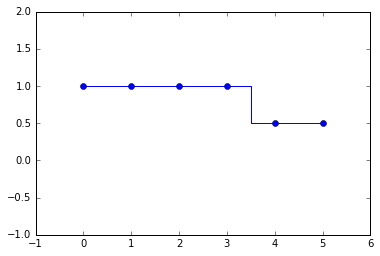

In [13]:
nx = 5 
x = np.linspace(0,5,6)
d = np.linspace(0,0,6)**2
h = np.where(x<=3,1.,0.5)
hu = np.zeros_like(h)
plt.step(x,h,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)
dl, dr, hl, hr, hul, hur   = getMusclReconstr(d,h,hu)

In [14]:
dinter,hm, hp, hum, hup = getHydrReconstr(dl,dr,hl,hr,hul,hur)

(-1, 2)

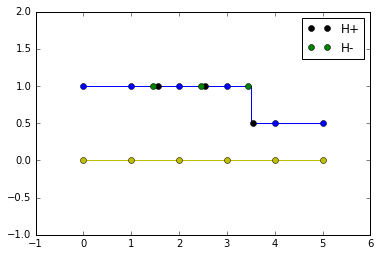

In [15]:
plt.step(x,h+d,'o',where='mid')
plt.step(x,d,'yo',where='mid')
plt.plot(x[2:-1]-0.45,hp+dinter,'ko',label='H+')
plt.plot(x[1:-2]+0.45,hm+dinter,'go',label='H-')
plt.legend(loc=0)
plt.xlim(-1,6)
plt.ylim(-1,2)

## Sources and interface fluxes

The interface fluxes are calculated as

$$F_{i+1/2}^- = F^*_{i+1/2} + S_{i+1/2-}$$
$$F_{i+1/2}^+ = F^*_{i+1/2} + S_{i+1/2+}$$

where $$F^*_{i+1/2} = \mathcal{F}(U^*_{i+1/2}(0, U_{i+1/2-}, U_{i+1/2+})$$ with $U^*(t,U_l,U_r)$ is the operator that solves the homogeneous Riemann problem for a given $t$ between states $U_l$ and $U_r$ and $\mathcal{F}(U)$ is the interface flux function

additionally

$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$
$$S_{i-1/2+} = \left(0, \frac{g}{2}(h_{i,l}^2 -h_{i-1/2+}^2)\right)^t$$

or better using $i+1/2\pm$
$$S_{i+1/2+} = \left(0, \frac{g}{2}(h_{i+1,l}^2 -h_{i+1/2+}^2)\right)^t$$
$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$

Given these definitions the semidiscrete system is

$$ \frac{d}{dt} U_{i}(t) + \frac{1}{\Delta x}(F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

where $$S_{c,i} = \left( 0, g\frac{h_{i,l}+h_{i,r}}{2}(d_{i,l}-d_{i,r}) \right)^T $$

In [16]:
g=9.81

In [17]:
def sources(dl,dr,hl,hr,hp,hm):
    sp = np.zeros((2,hl[1:].shape[0]))
    sm = np.zeros((2,hm.shape[0]))
    sc = np.zeros((2,dl.shape[0]))
    sp[1,:] = 0.5*g*(hl[1:]**2-hp**2) #S_{i+1/2+}   
    sm[1,:] = 0.5*g*(-hm**2+hr[:-1]**2)    #S_{i+1/2-}
    sc[1,:] = 0.5*g*(hl+hr)*(dl-dr) #S_{c,i}
    return sp, sm, sc

In [18]:
sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)
sp,sp,sc

(array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]))

In [19]:
def flux(h,u):
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

In [20]:
def fluxes_sources(d,hn,hun):
    """
        Calcula los flujos en cada interfaz,
        Tambien entrega el termino fuente centrado
        de la reconstruccion hidrostatica
        Retorna:
        
        fp: F_{i+1/2^+} de 2xninterfaces=2x(nx+1)
        fm: F_{i+1/2^-} de 2xninterfaces=2x(nx+1)
        sc: 
        ninterfaces = nx+1: (indice 0), desde 1+1/2...nx+1/2
        
    """
    nx = d.shape[0]-4
    fs = np.zeros((2,nx+1))
    fp = np.zeros((2,nx+1))
    fm = np.zeros((2,nx+1))
    
    dl, dr, hl, hr, hul, hur = getMusclReconstr(d,hn,hun)
    
    dinter, hm, hp, hum, hup = getHydrReconstr(dl,dr,hl,hr,hul,hur)
    sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)
    
    #ahora calcular los flujos estrella
    for i in range(nx+1):        
        hs,us = nswe1.roe(hm[i],hum[i],hp[i],hup[i])
        fs[:,i] = flux(hs,us)
        
    #calculate fp and fm
    fp = fs + sp
    fm = fs + sm
    
    return fp, fm, sc

For debugging

(-1, 2)

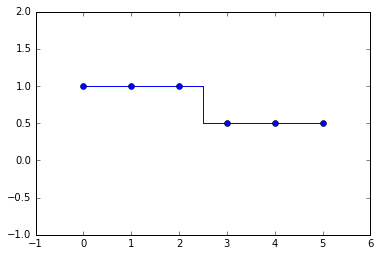

In [22]:
import nswe1
nx = 2
x = np.linspace(0,5,nx+4)
d = np.linspace(0,0,nx+4)**2
h = np.where(x<=2,1.,0.5)
hu = np.zeros_like(h)
plt.step(x,h,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)

In [23]:
dl, dr, hl, hr, hul, hur   = getMusclReconstr(d,h,hu)
dinter, hm, hp, hum, hup = getHydrReconstr(dl,dr,hl,hr,hul,hur)
sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)
fs = np.zeros((2,hm.shape[0]))

#ahora calcular los flujos estrella
for i in range(nx+1):        
    hs,us = nswe1.roe_surf(hm[i],hum[i],hp[i],hup[i])
    fs[:,i] = flux(hs,us)
        
#calculate fp and fm
fp = fs + sp
fm = fs + sm   

# Boundary conditions

In [24]:
def bcs_open(d,h0,hu0):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    db = 1.*d
    hb = 1.*h0
    hub = 1.*hu0
    db[0] = db[3]
    db[1] = db[2]
    hb[0] = hb[3]
    hb[1] = hb[2]
    hub[0] = hub[3]
    hub[1] = hub[2]
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[-1] = hb[-4]
    hb[-2] = hb[-3]
    hub[-1] = hub[-4]    
    hub[-2] = hub[-3]    
    return db,hb,hub

In [25]:
def bcs_cerrado(d,h0,hu0):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    db = 1.*d
    hb = 1.*h0
    hub = 1.*hu0
    db[0] = db[3]
    db[1] = db[2]
    hb[0] = h0[3]
    hb[1] = h0[2]
    hub[0] = -hu0[3]
    hub[1] = -hu0[2]
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[-1] = h0[-4]
    hb[-2] = h0[-3]
    hub[-1] = -hu0[-4]    
    hub[-2] = -hu0[-3]    
    return db,hb,hub

# CFL condition

In [26]:
def setdt(h0,hu0,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h0[:]>1e-5, hu0[:]/h0[:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h0[:]))
    dt = cfl*dx/np.max(s)
    return dt

# Function for iterations

(-1, 15)

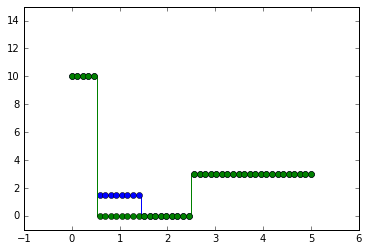

In [27]:
nx = 40
x = np.linspace(0,5,nx+4)
dx = np.diff(x)[0]

nt = 100
t = np.zeros((nt+1,))
cfl = 0.45

# d = np.linspace(0,0.5,nx+4)**2
# d = np.exp(-(x-2.5)**2/0.2)*1.2
d = np.where(x<=2.5,0.0,3.0)
d = np.where(x<=0.5,10.0,d)

h = np.zeros((nt+1,nx+4))
hu = np.zeros((nt+1,nx+4))
h[0,:] = np.where(x<=1.5,1.5-d,0.0)
h[0,:] = np.where(h[0,:]<=0,0.0,h[0,:])                 
hu[0,:] = 0.

hu = np.zeros_like(h)
plt.step(x,h[0,:]+d,'o',where='mid')
plt.step(x,d,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,15)

In [28]:
for n in range(nt):
    d,h[n,:],hu[n,:] = bcs_open(d,h[n,:],hu[n,:])    
    dt = setdt(h[n,:],hu[n,:],dx,cfl)
    t[n+1] = t[n] + dt
    fp,fm,sc = fluxes_sources(d,h[n,:],hu[n,:])
    h[n+1,2:-2] = h[n,2:-2] -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]*dt/dx
    hu[n+1,2:-2] = hu[n,2:-2] -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]*dt/dx

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide



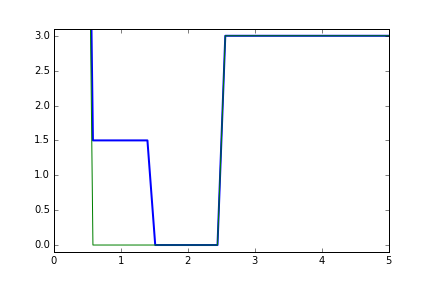
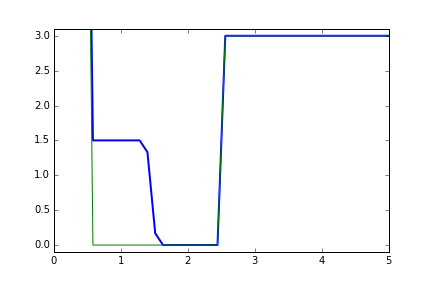
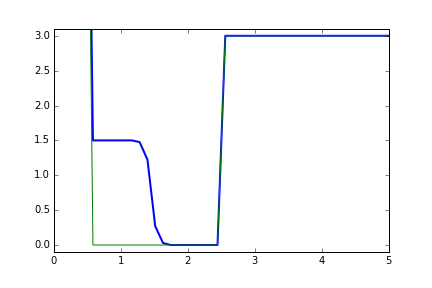
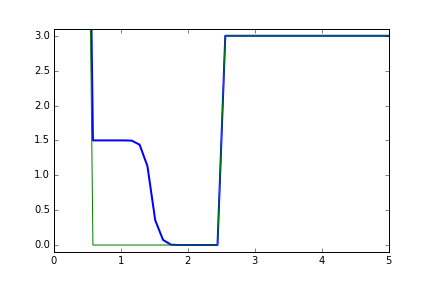
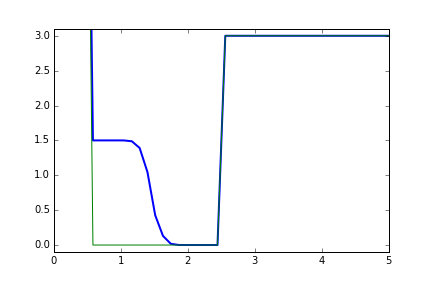
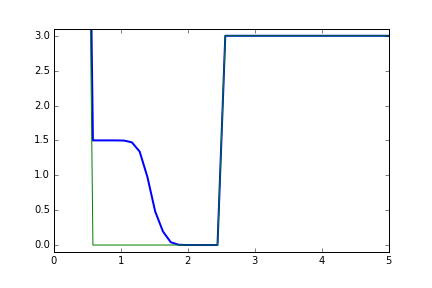
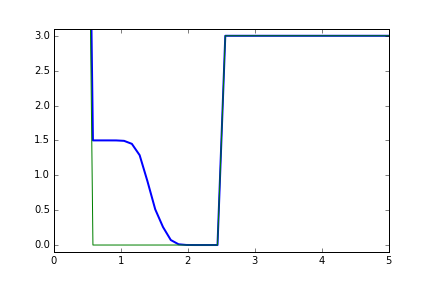
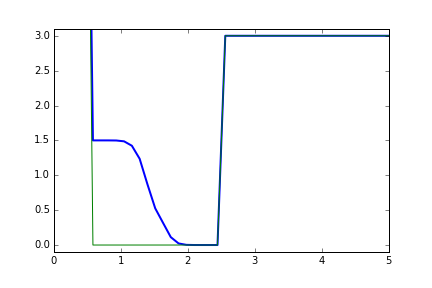
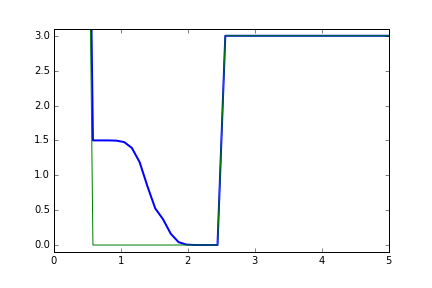
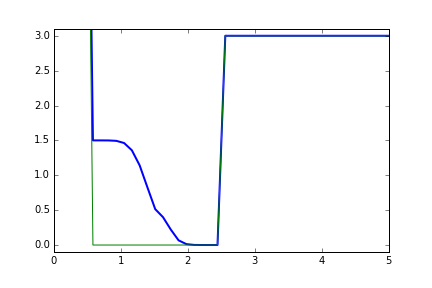
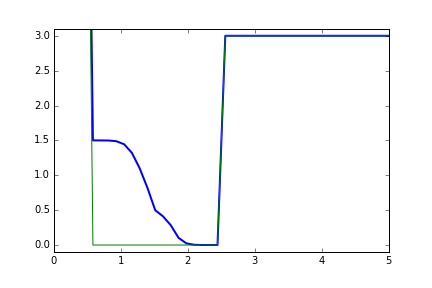
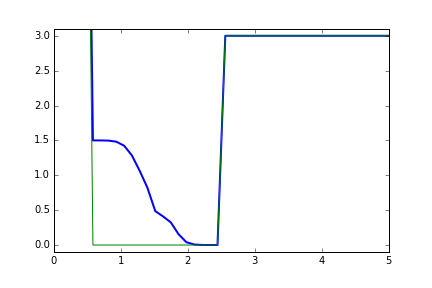
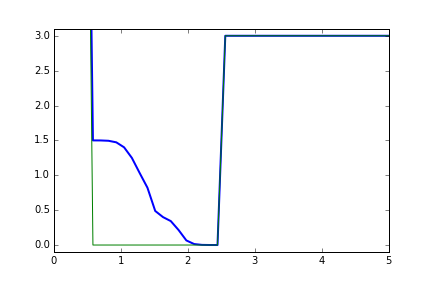
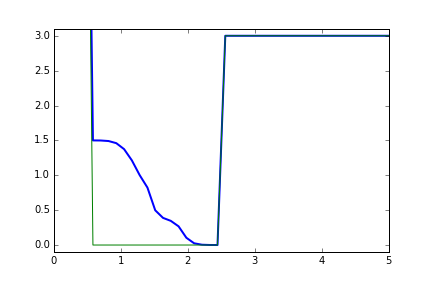
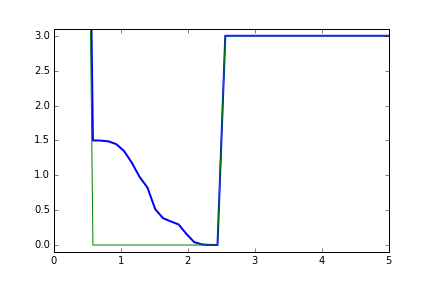
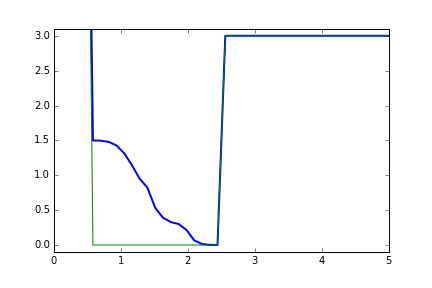
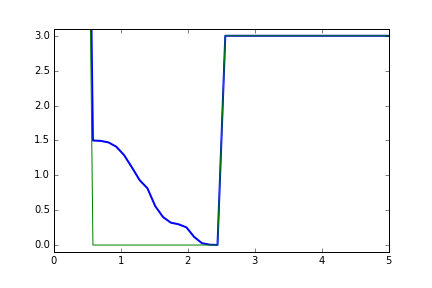
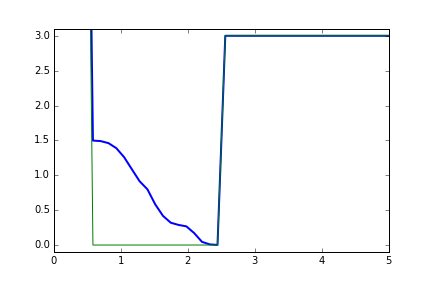
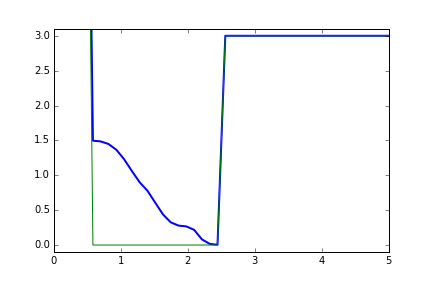
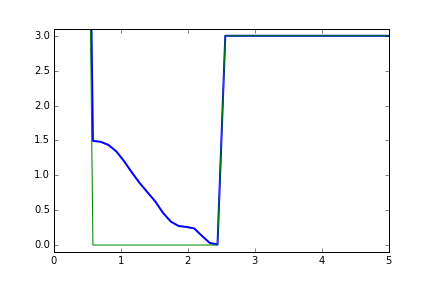
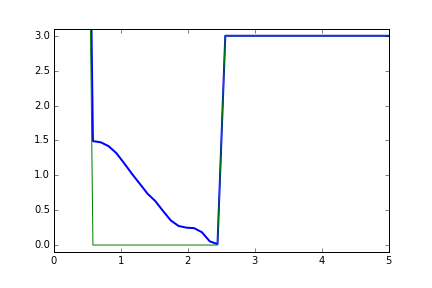
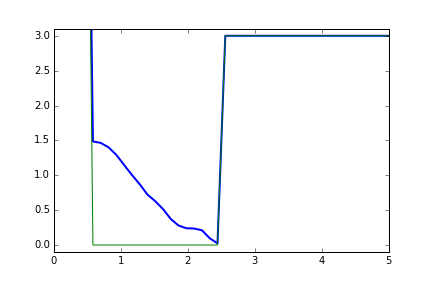
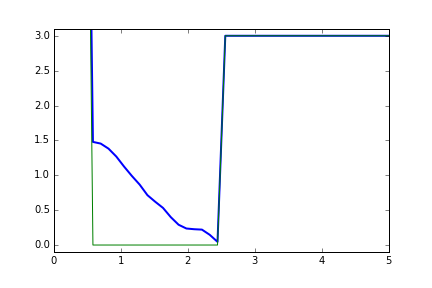
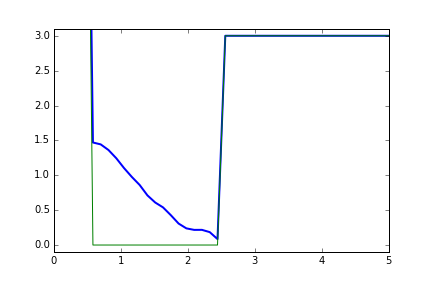
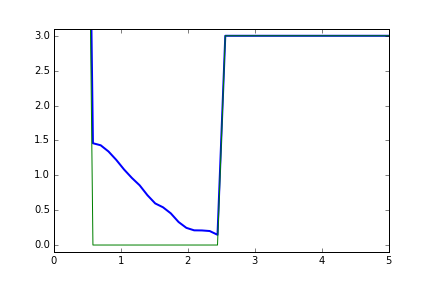
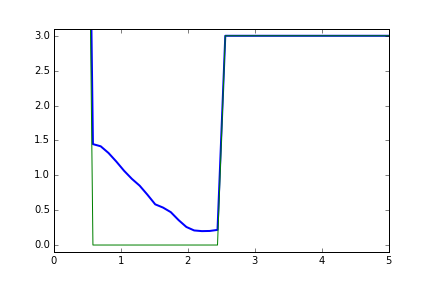
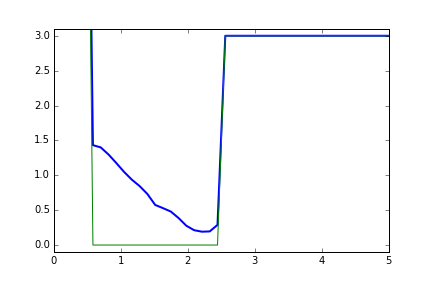
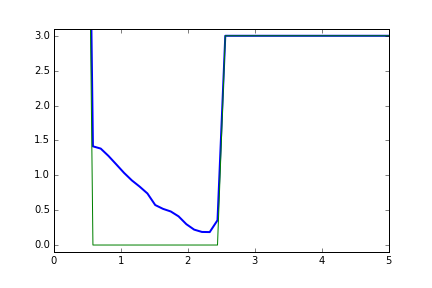
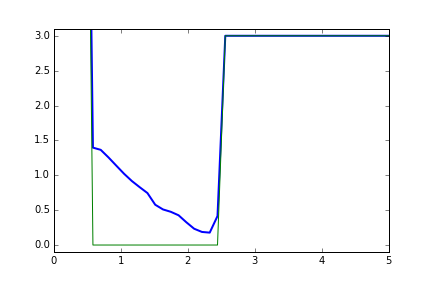
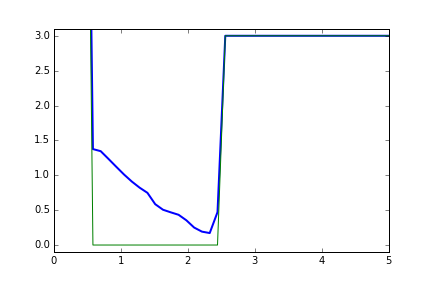
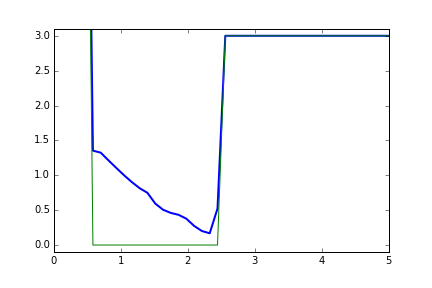
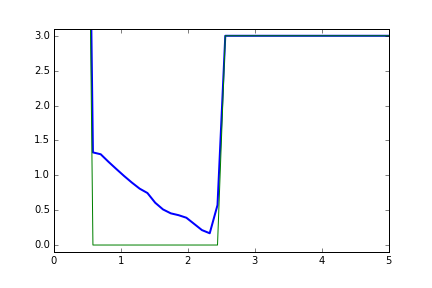
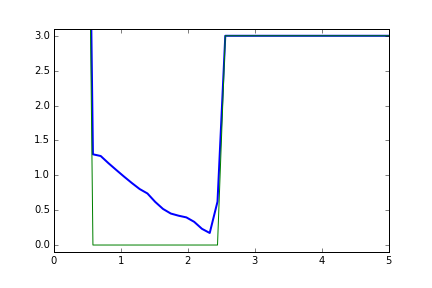
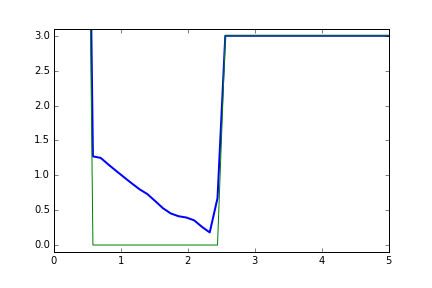
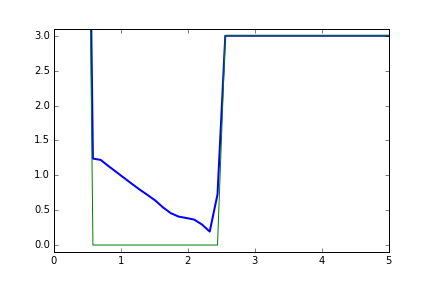
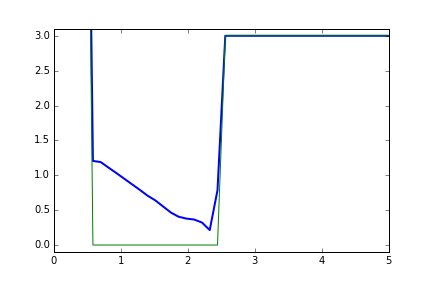
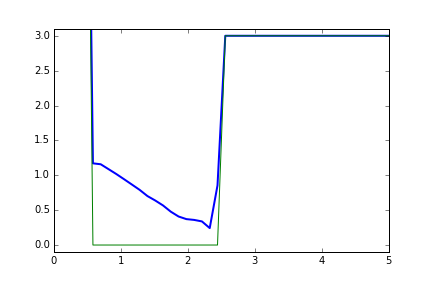
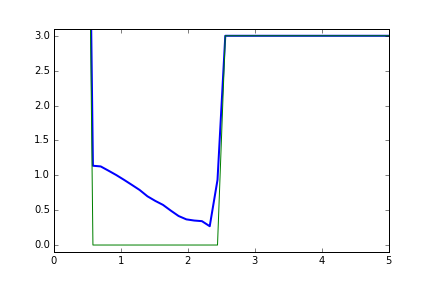
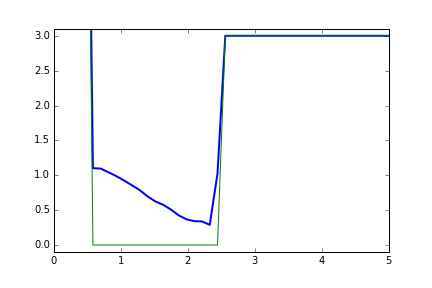
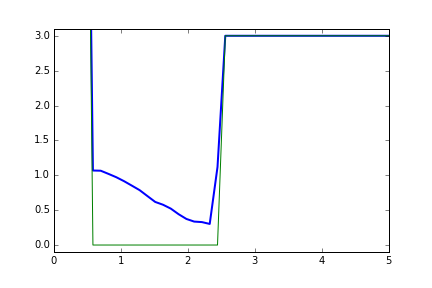
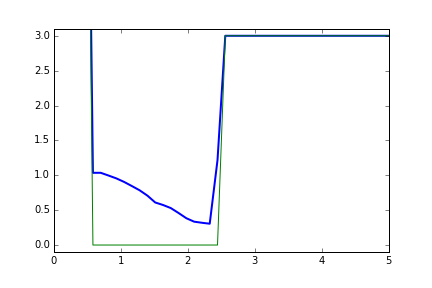
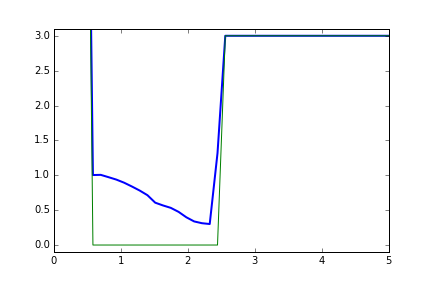
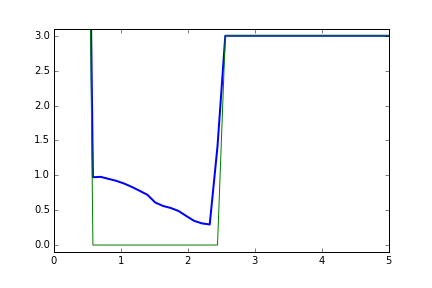
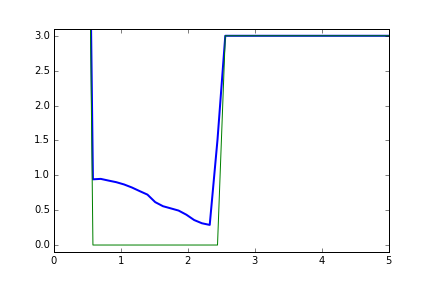
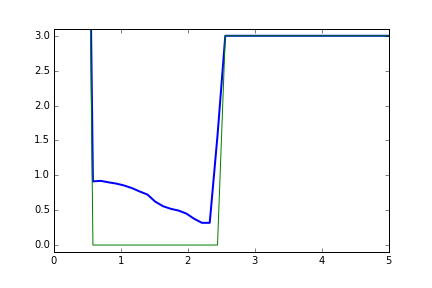
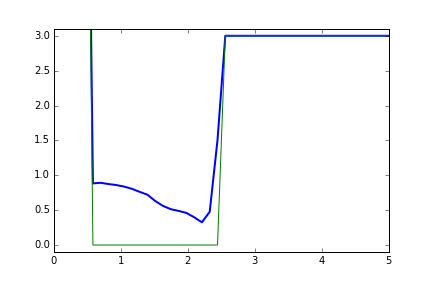
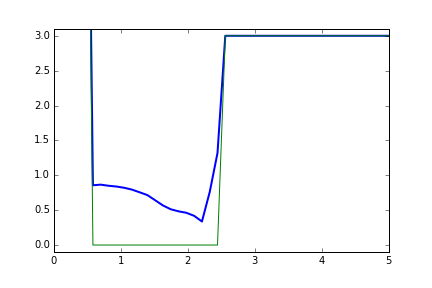
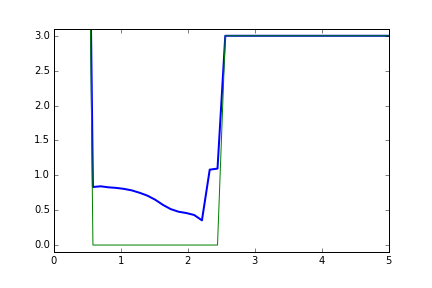
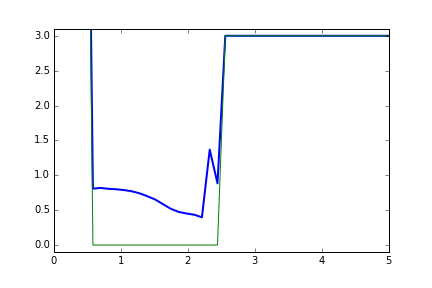
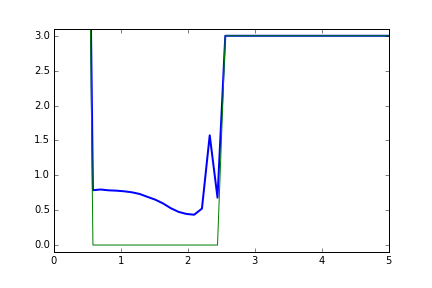
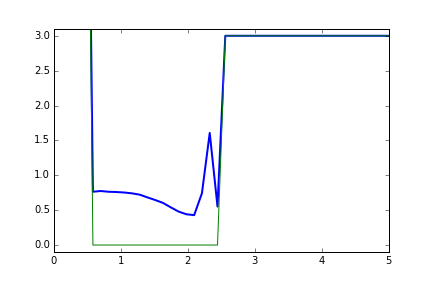
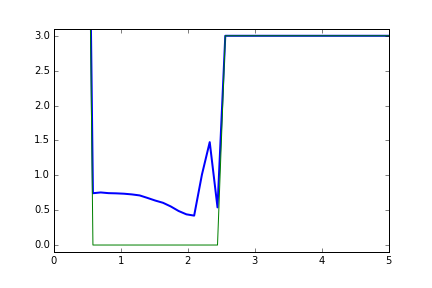
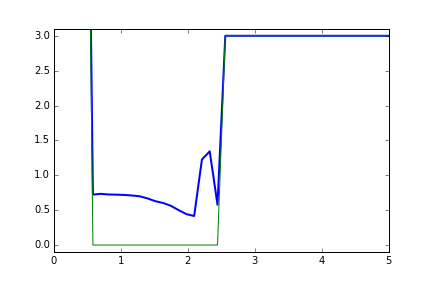
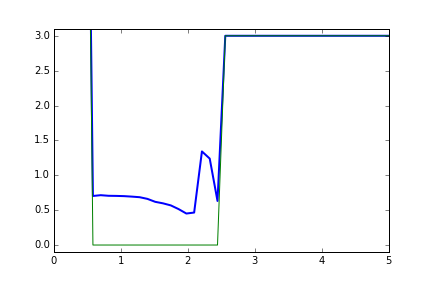
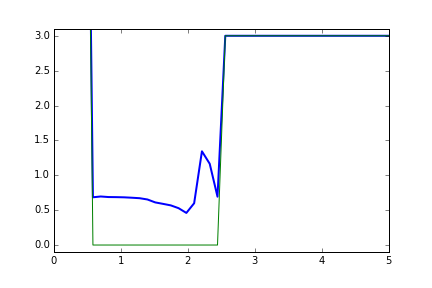
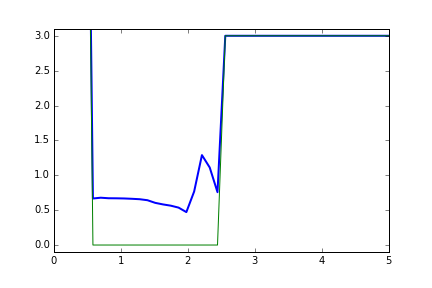
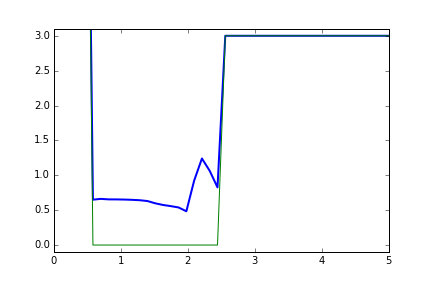
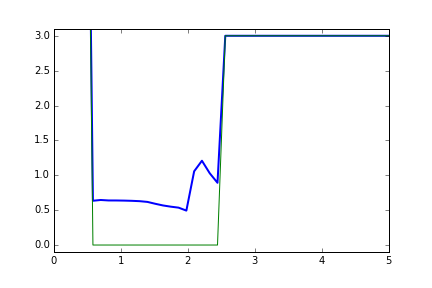
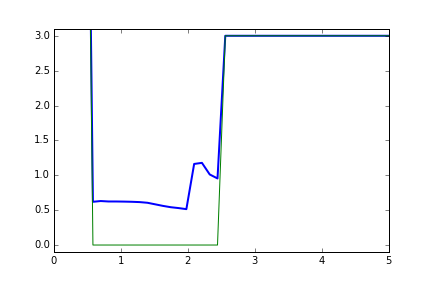
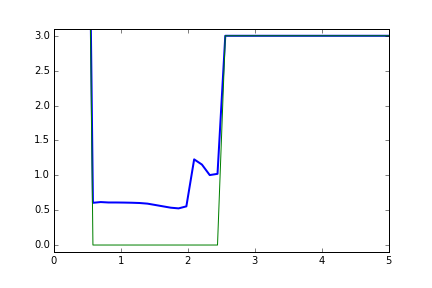
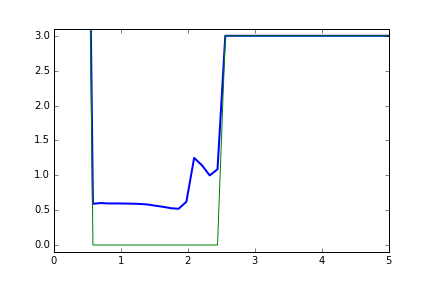
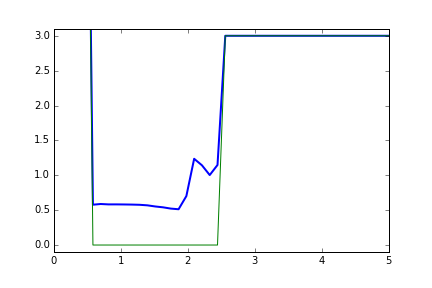
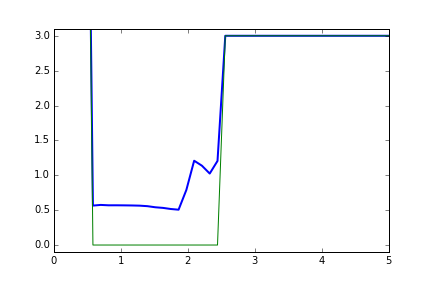
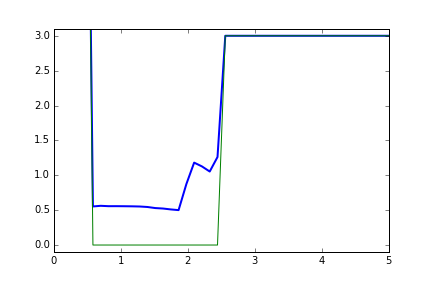
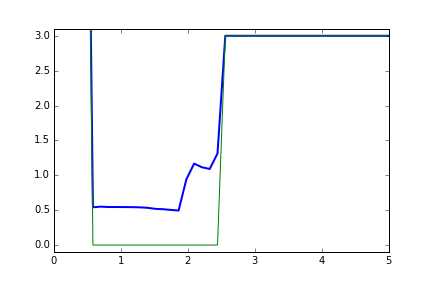
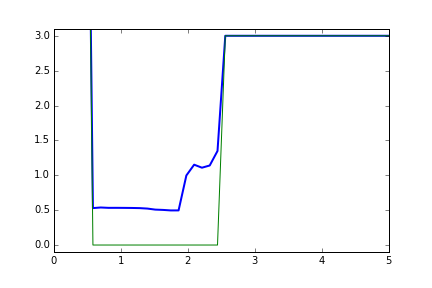
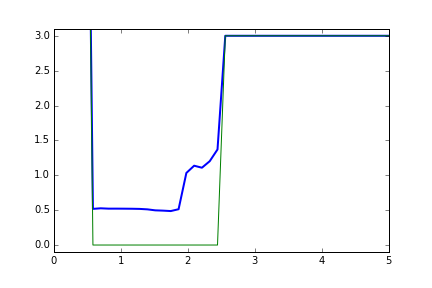
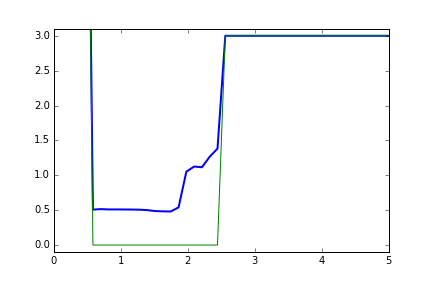
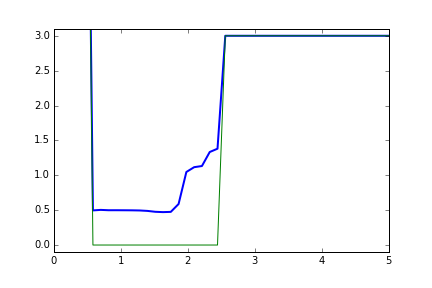
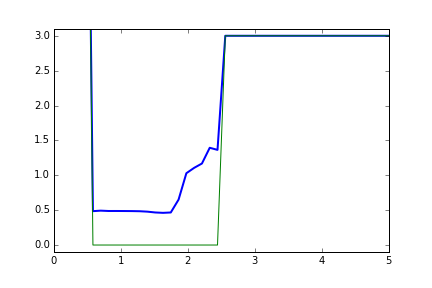
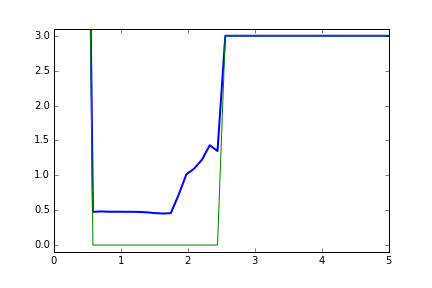
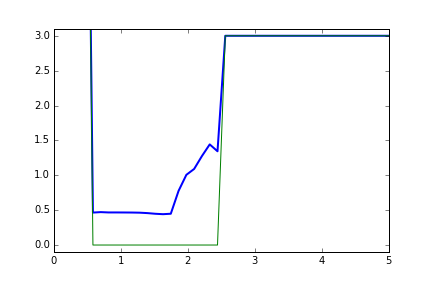
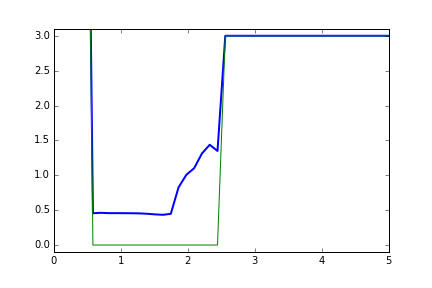
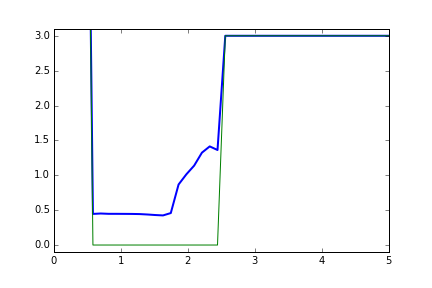
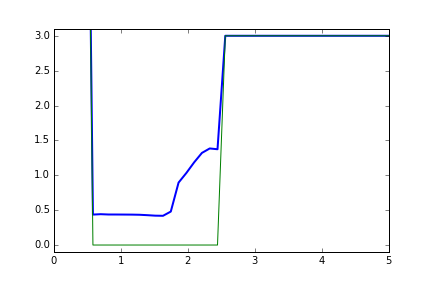
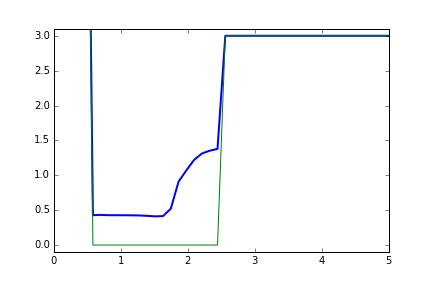
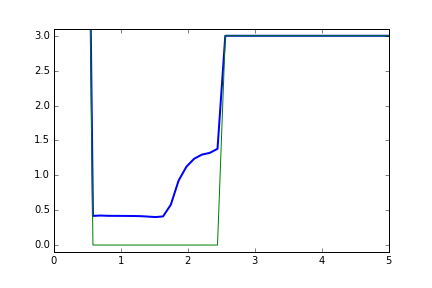
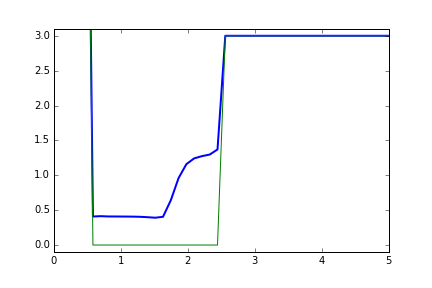
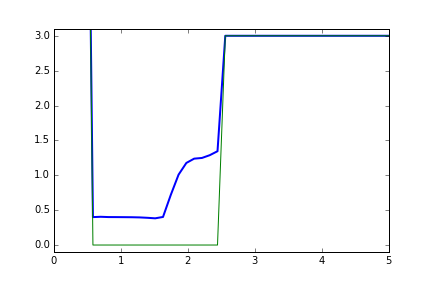
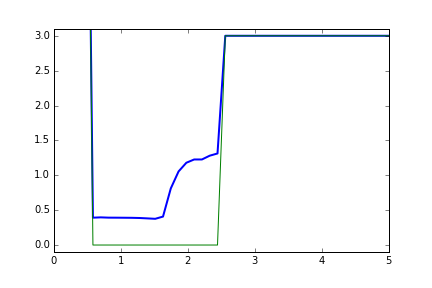
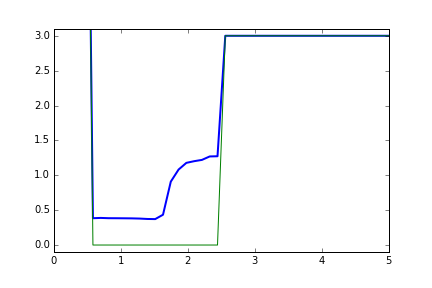
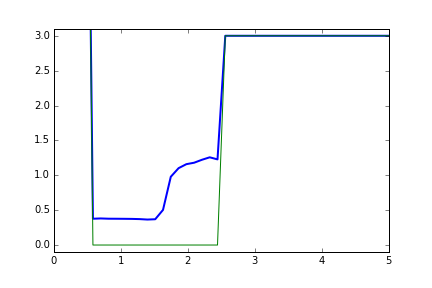
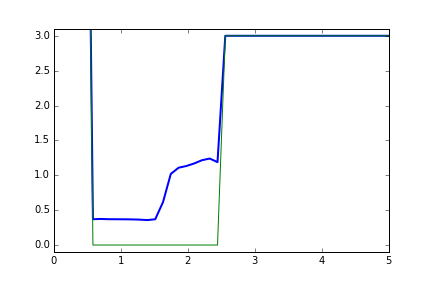
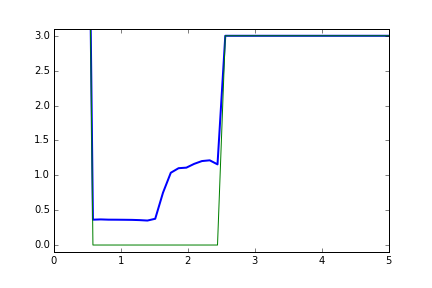
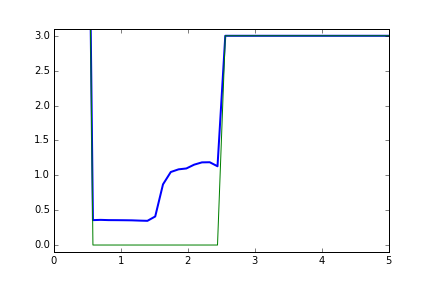
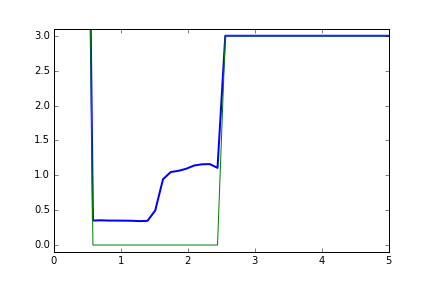
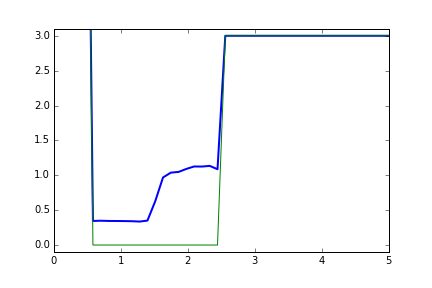
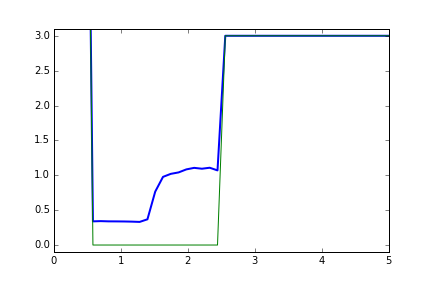
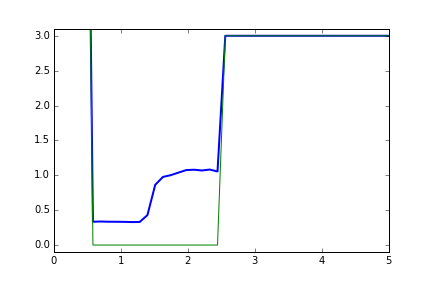
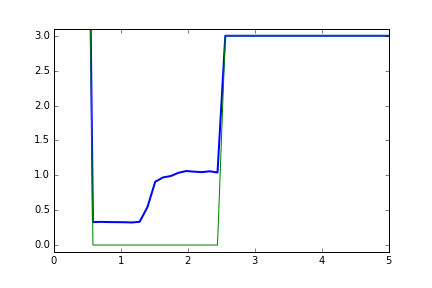
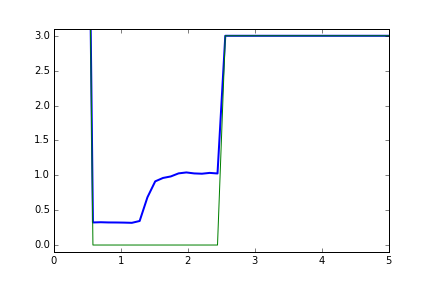
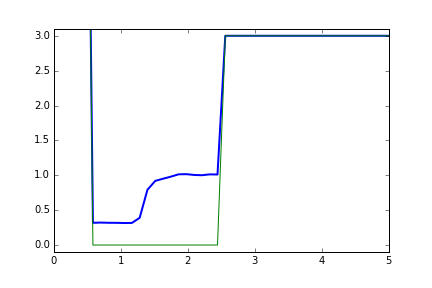
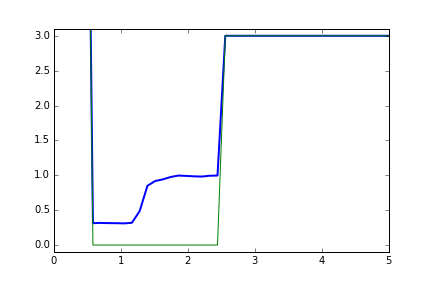
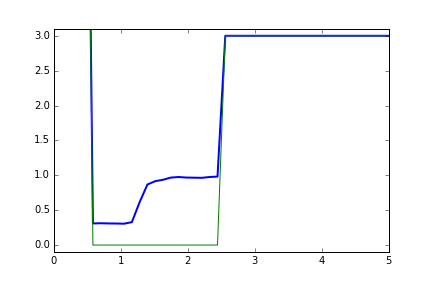
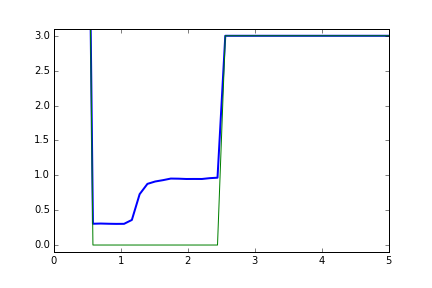
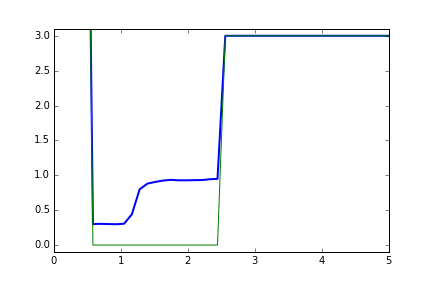
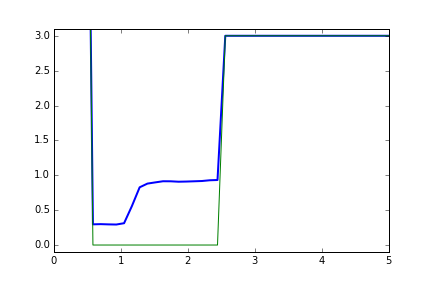
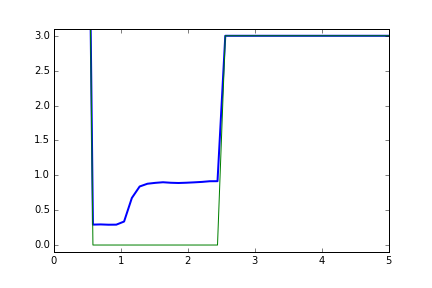
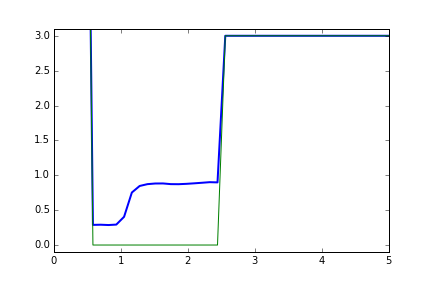

In [29]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 3.1))
line, = ax.plot([], [], lw=2)
ax.plot(x,d)

def animate(i):
    line.set_data(x, h[i,:]+d)
    return line,

animation.FuncAnimation(fig, animate, frames=nt-1, interval=45)

# RK 4

In [30]:
def rkstep(d,h0,hu0):
    d,h0, hu0 = bcs_open(d,h0,hu0)
    fp,fm,sc = fluxes_sources(d,h0,hu0)
    nx = h0.shape[0]-4
    F = np.zeros((2,nx+4))
    F[0,2:-2] = -1./dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]*1./dx
    F[1,2:-2] = -1./dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]*1./dx       
    return F

In [31]:
n=0
for n in range(nt):
    dt = setdt(h[n,:],hu[n,:],dx,cfl)
    t[n+1] = t[n] + dt

    k1 = rkstep(d,h[n,:],hu[n,:])
    k2 = rkstep(d,h[n,:]+0.5*k1[0,:]*dt, hu[n,:]+0.5*k1[1,:]*dt)
    k3 = rkstep(d,h[n,:]+0.5*k2[0,:]*dt, hu[n,:]+0.5*k2[1,:]*dt)
    k4 = rkstep(d,h[n,:]+k3[0,:]*dt, hu[n,:]+k3[1,:]*dt)
    h[n+1,:] = h[n,:] + dt/6.*(k1[0,:]+2.*k2[0,:]+2.*k3[0,:]+k4[0,:])
    hu[n+1,:] = hu[n,:] + dt/6.*(k1[1,:]+2.*k2[1,:]+2.*k3[1,:]+k4[1,:])


/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide



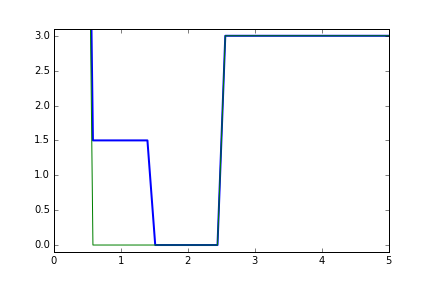
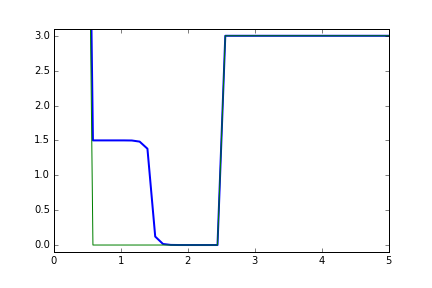
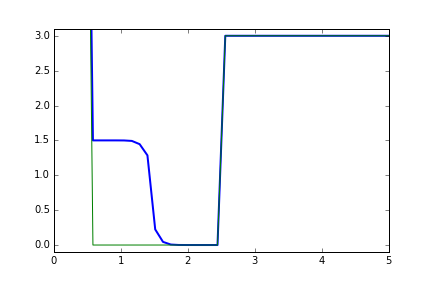
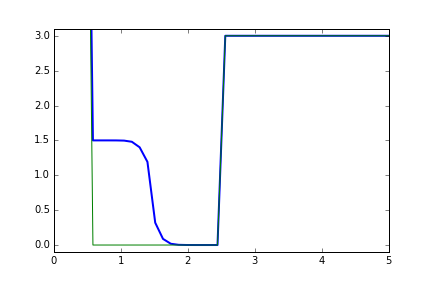
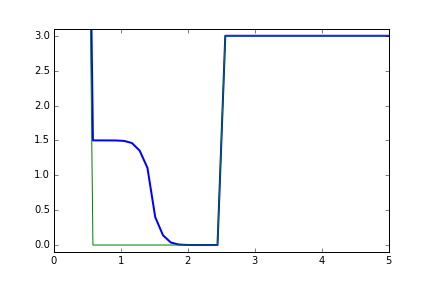
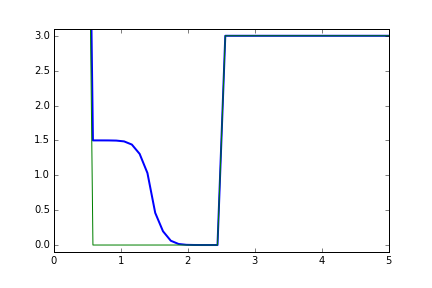
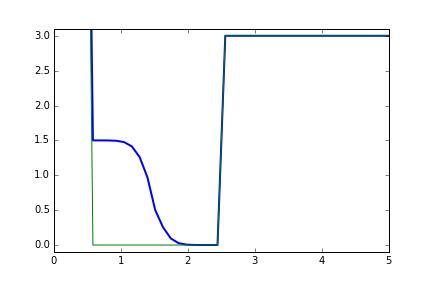
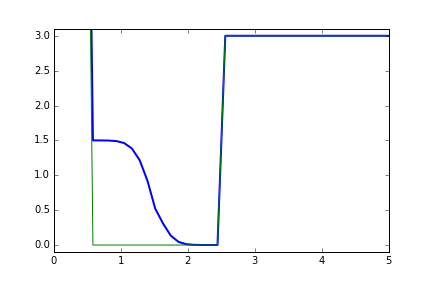
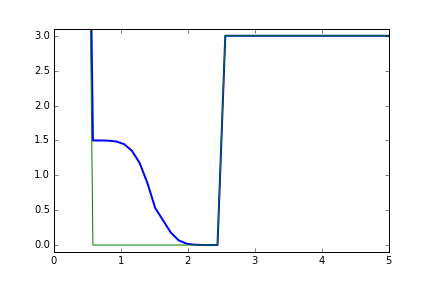
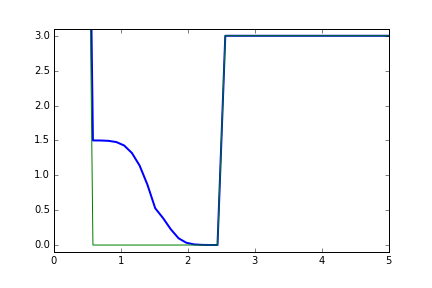
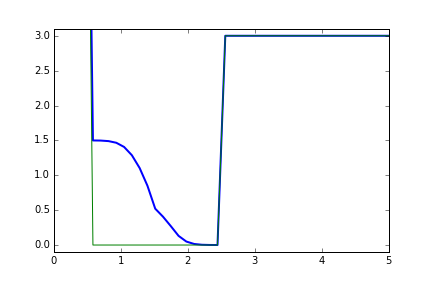
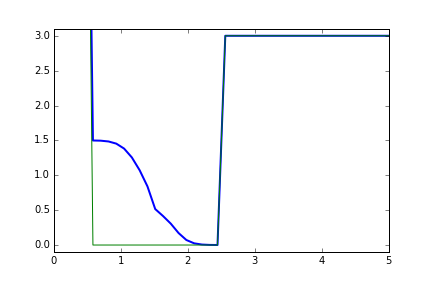
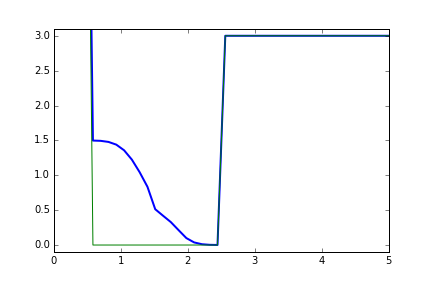
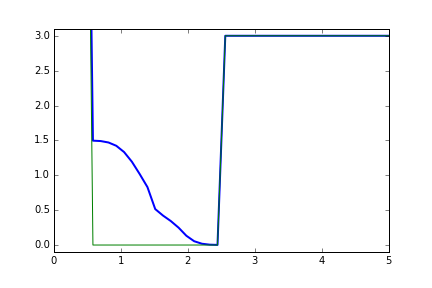
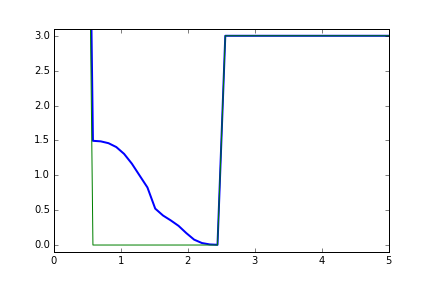
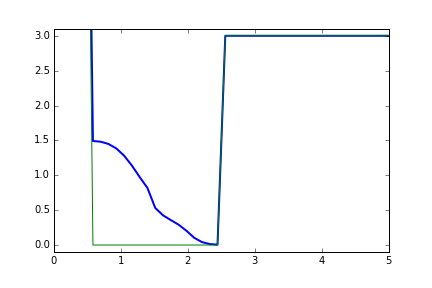
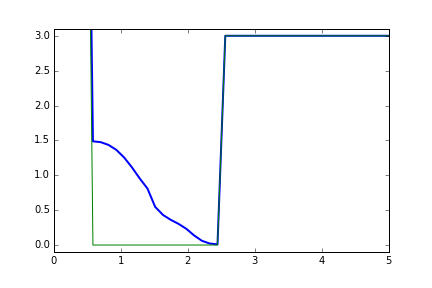
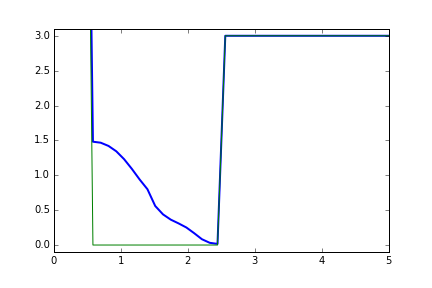
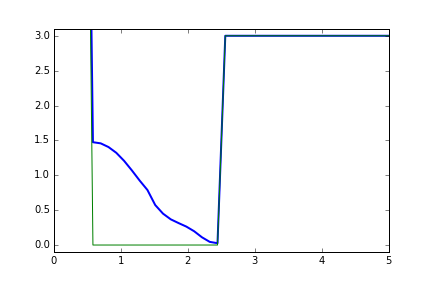
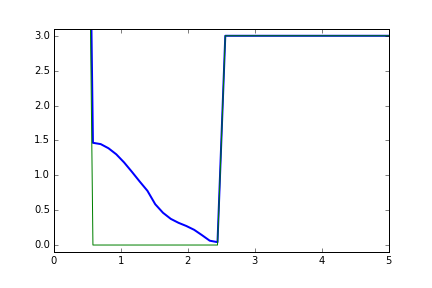
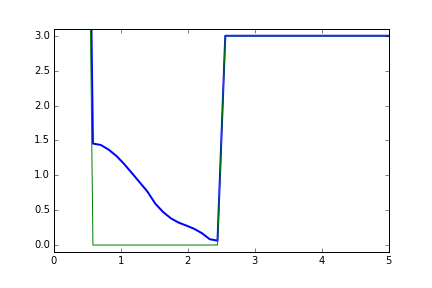
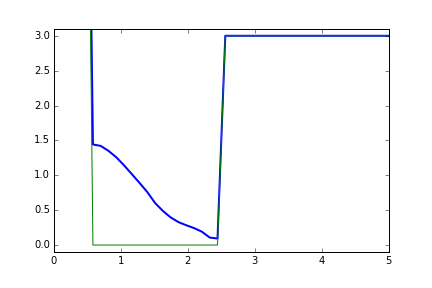
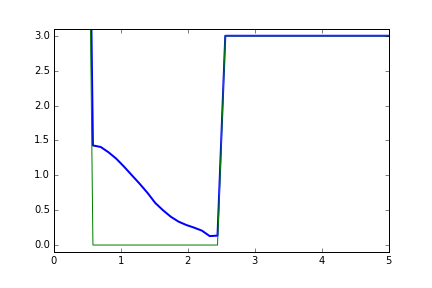
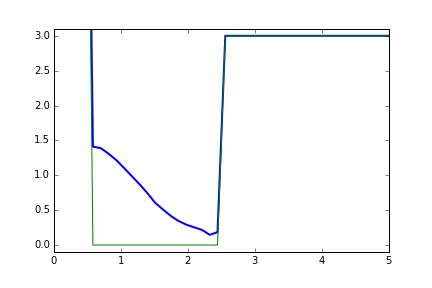
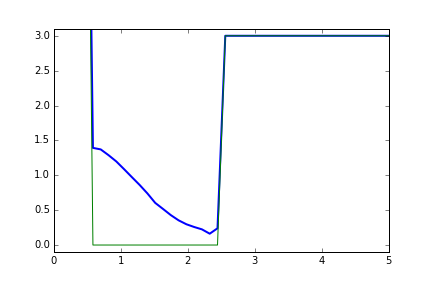
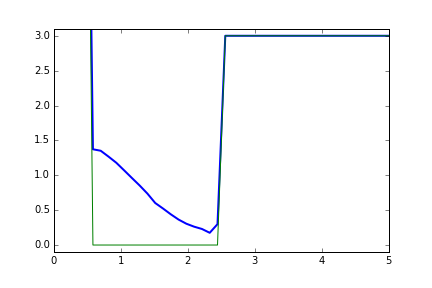
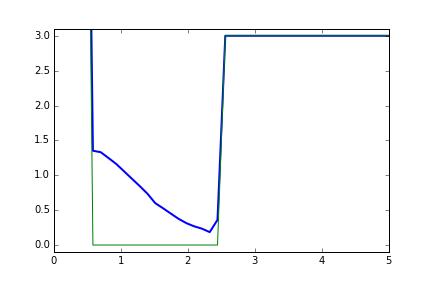
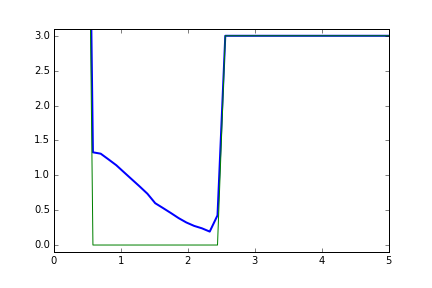
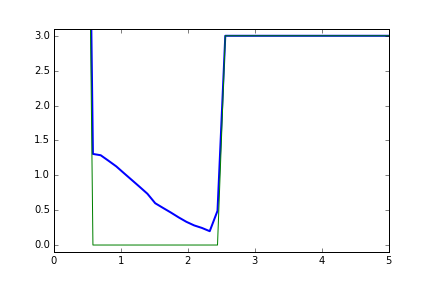
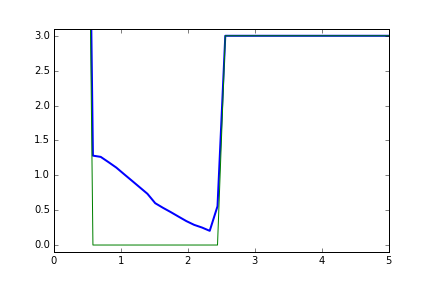
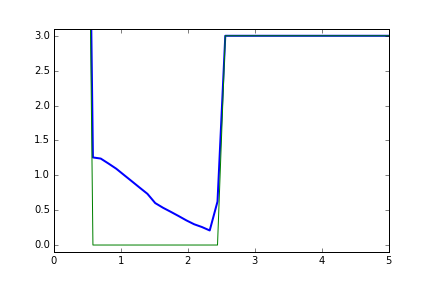
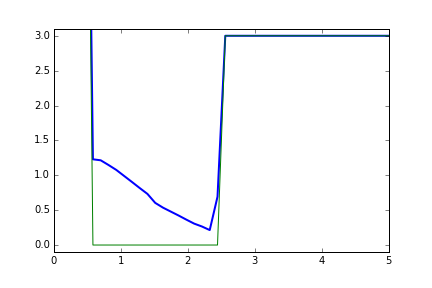
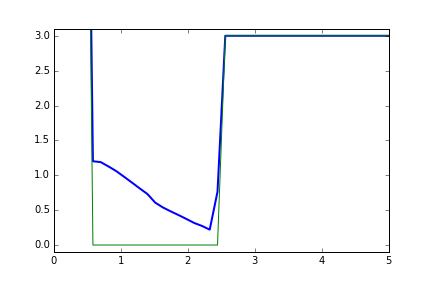
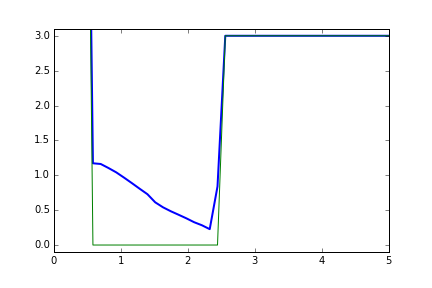
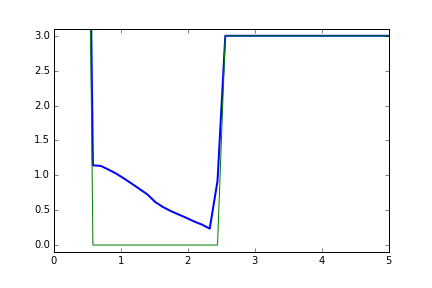
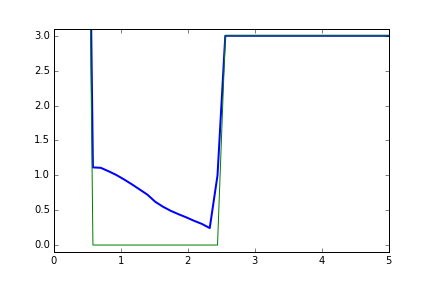
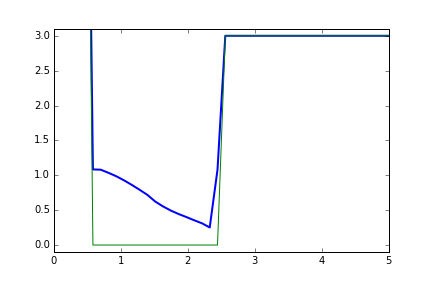
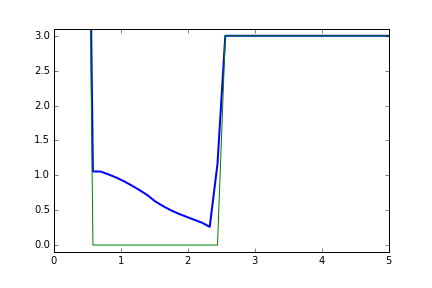
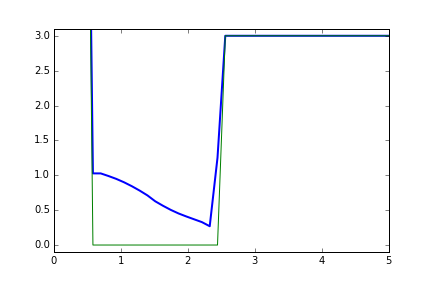
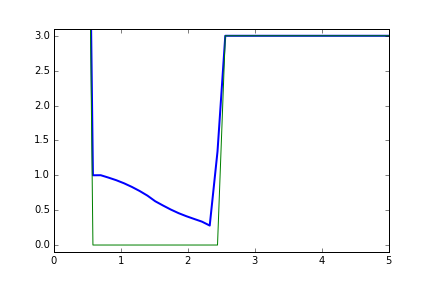
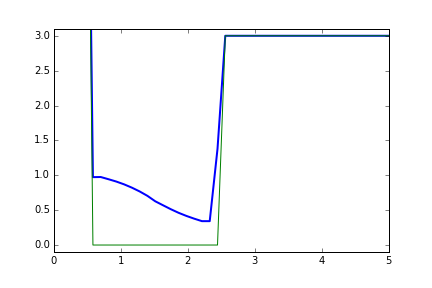
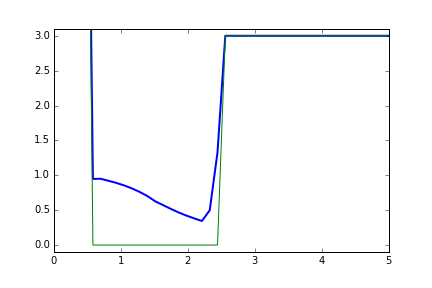
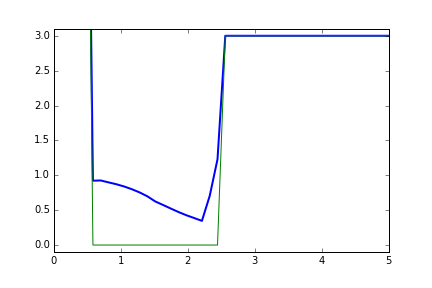
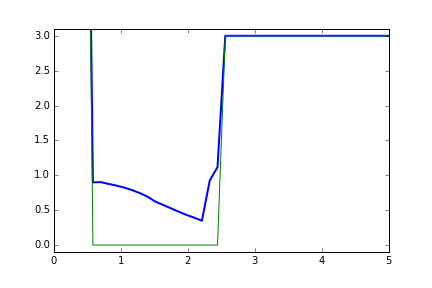
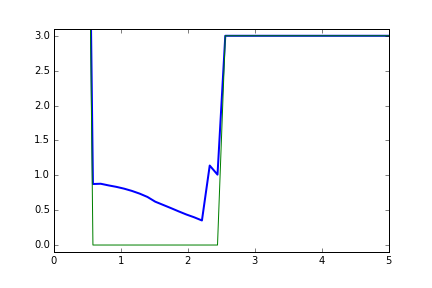
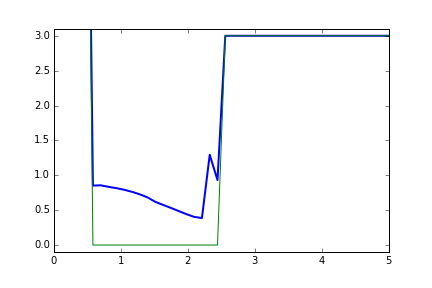
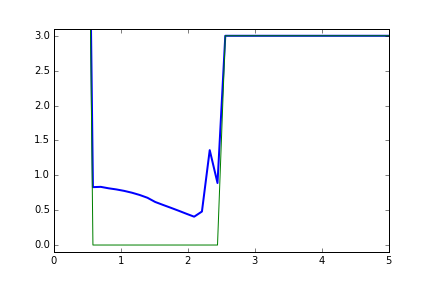
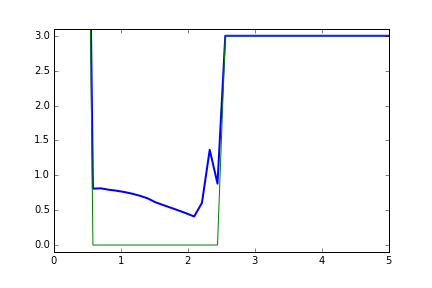
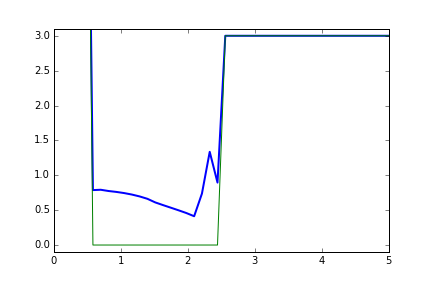
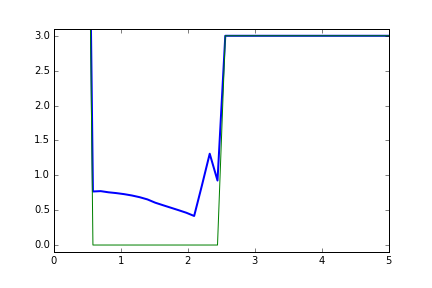
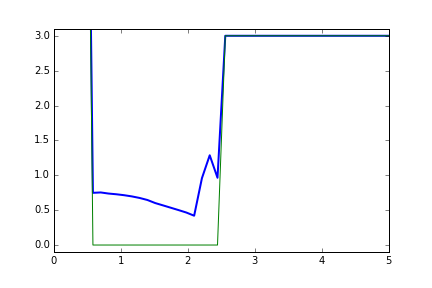
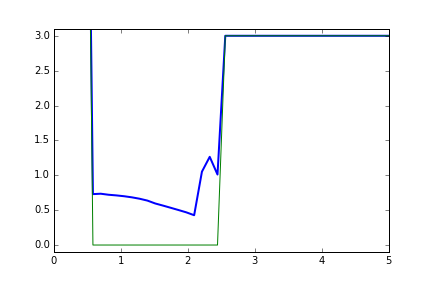
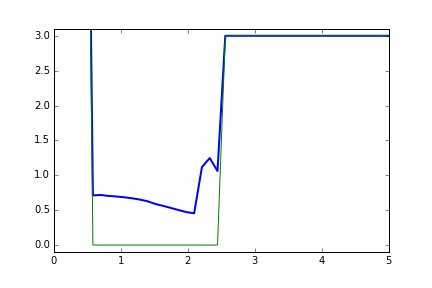
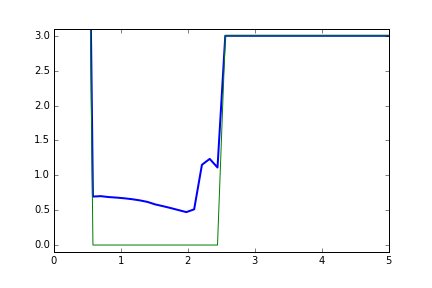
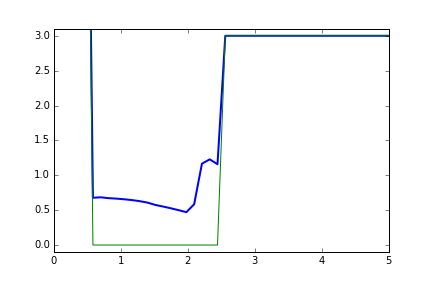
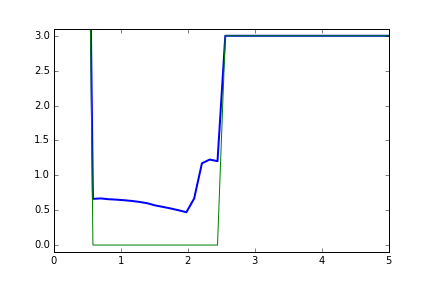
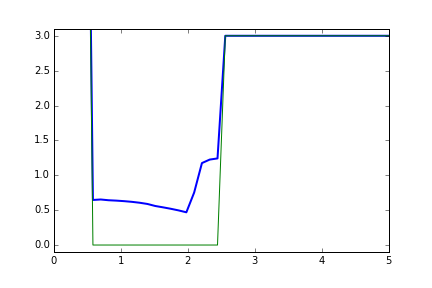
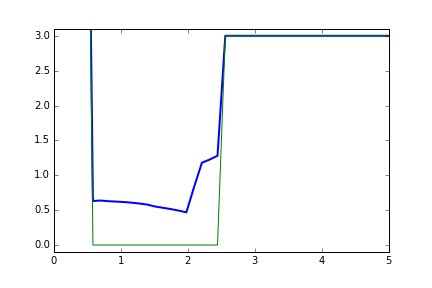
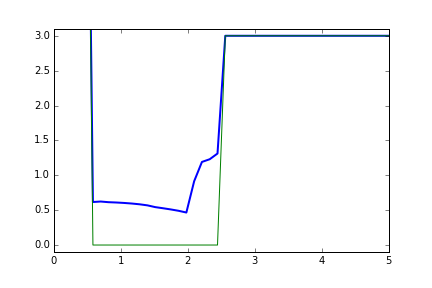
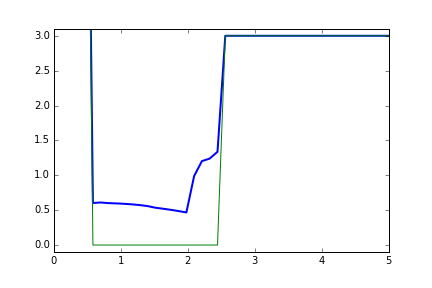
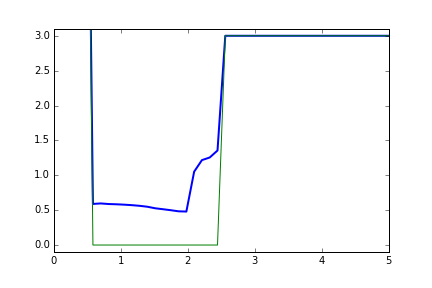
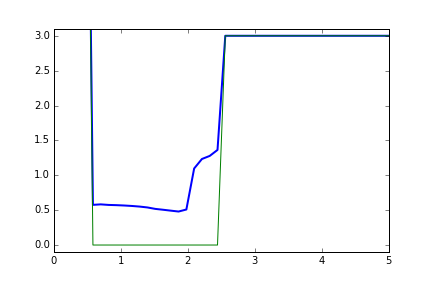
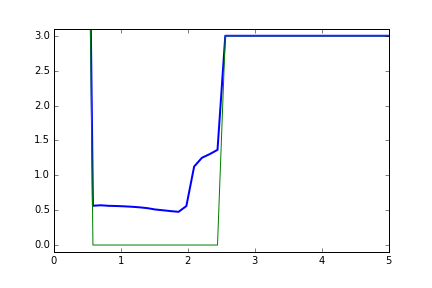
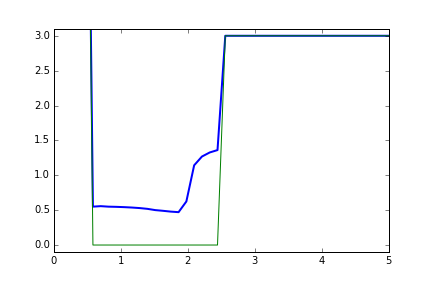
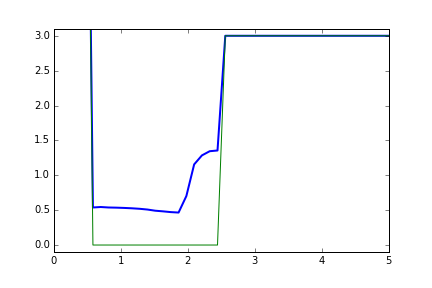
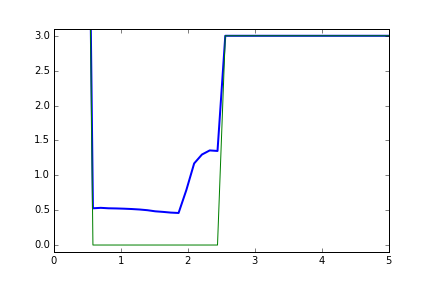
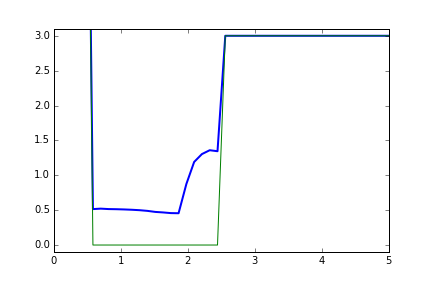
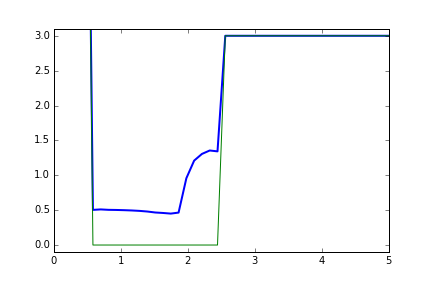
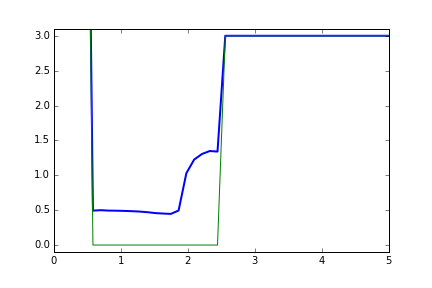
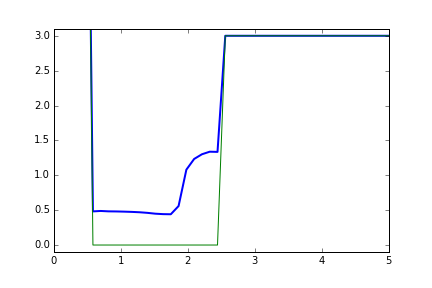
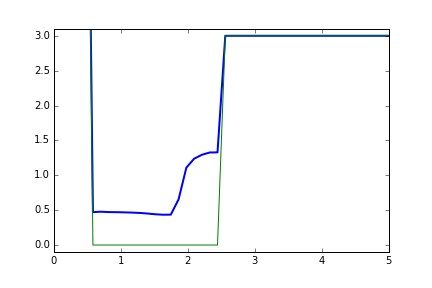
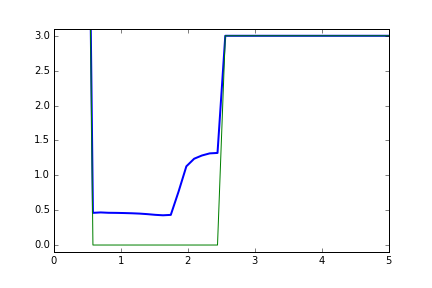
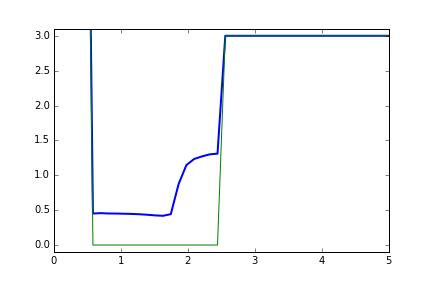
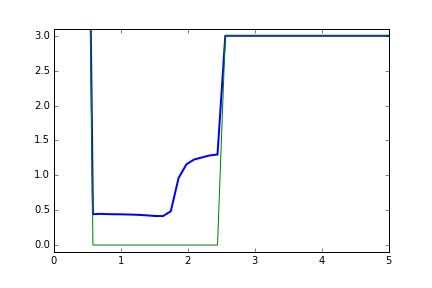
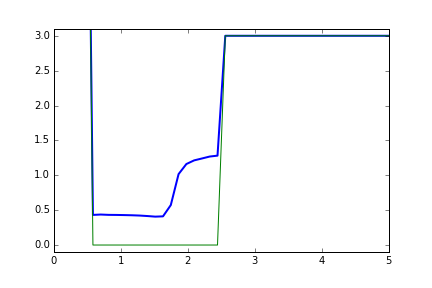
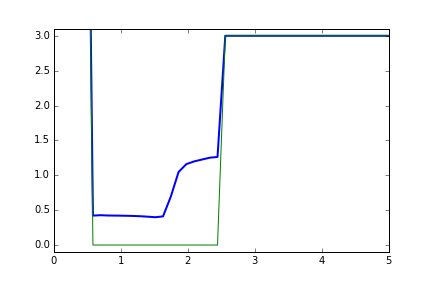
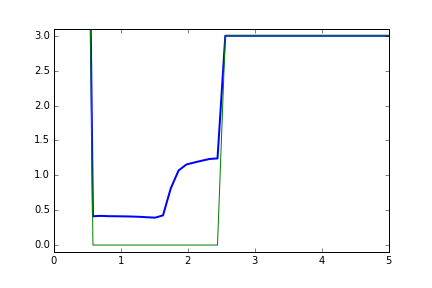
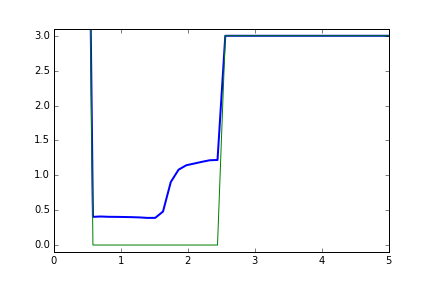
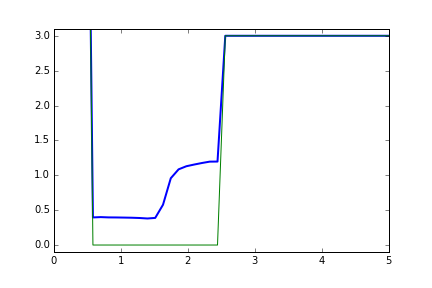
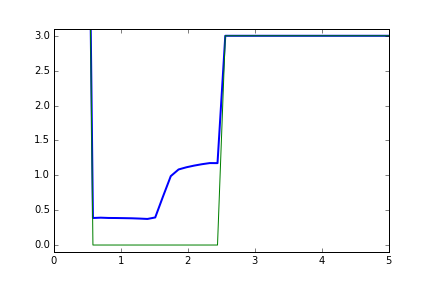
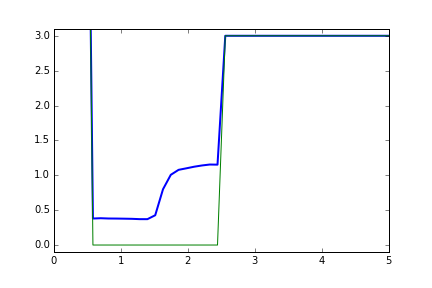
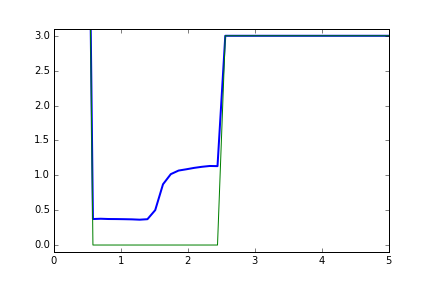
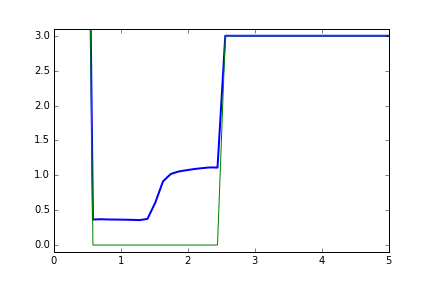
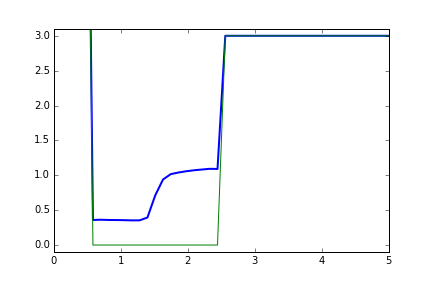
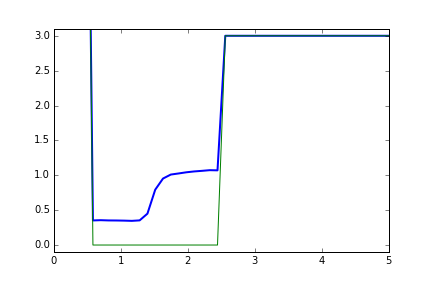
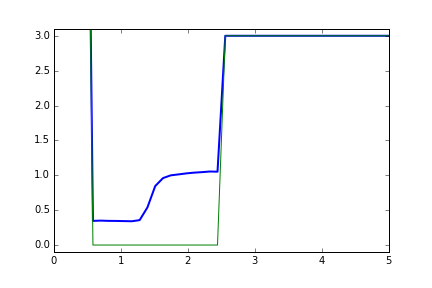
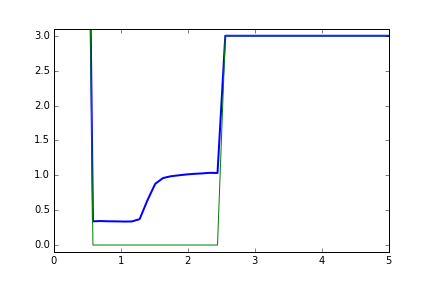
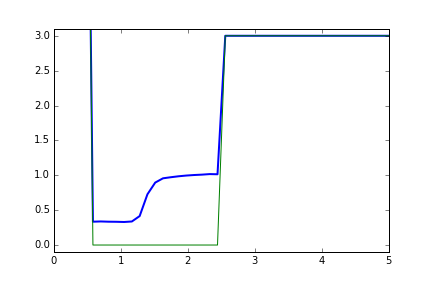
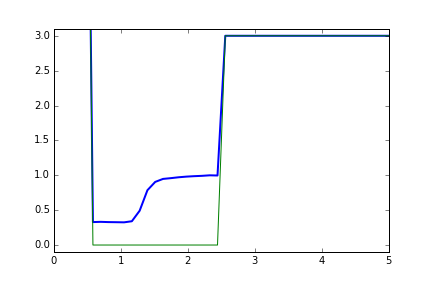
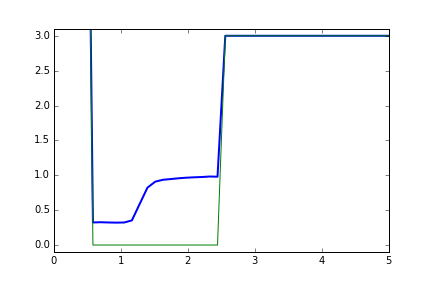
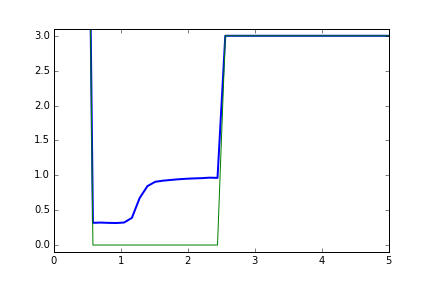
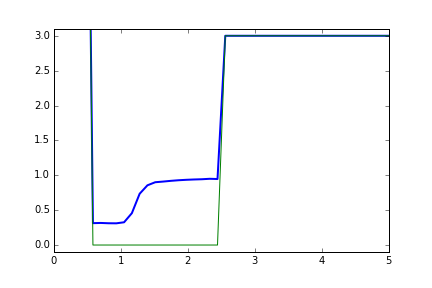
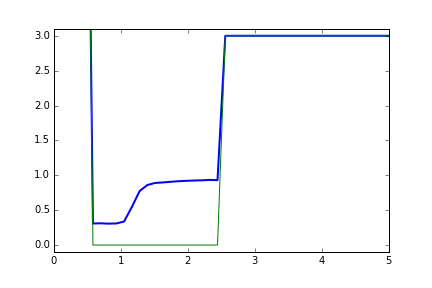
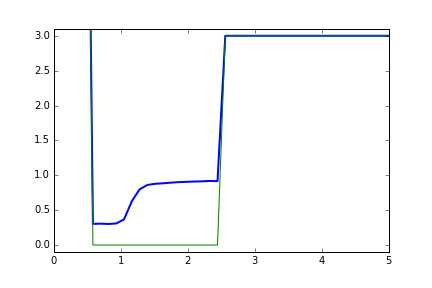
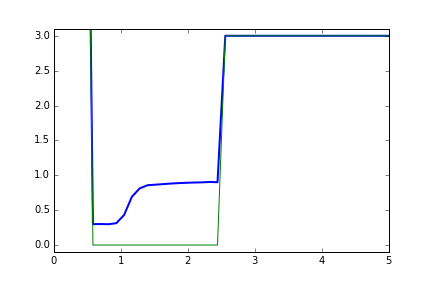
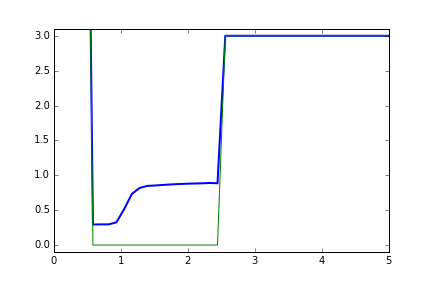
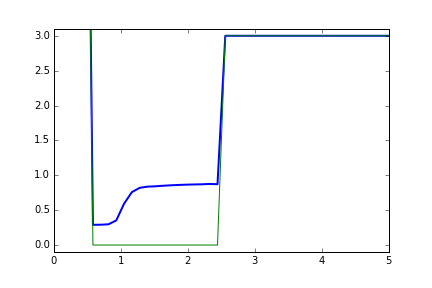
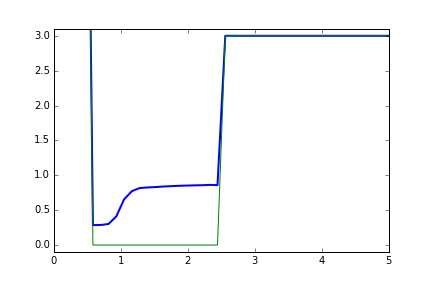
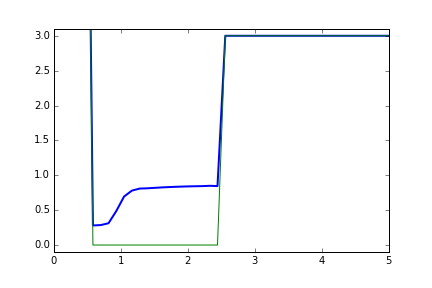

In [32]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 3.1))
line, = ax.plot([], [], lw=2)
ax.plot(x,d)

def animate(i):
    line.set_data(x, h[i,:]+d)
    return line,

animation.FuncAnimation(fig, animate, frames=nt-1, interval=45)